# NLP - Session 15 - TF20 | Keras | Word Embedding

#### What is Word Embedding?
Natural Language Processing(NLP) refers to computer systems designed to understand human language. Human language, like English or Hindi consists of words and sentences, and NLP attempts to extract information from these sentences.

Machine learning and deep learning algorithms only take numeric input so how do we convert text to numbers?

A word embedding is a learned representation for text where words that have the same meaning have a similar representation. Embeddings translate large sparse vectors into a lower-dimensional space that preserves semantic relationships. Word embeddings is a technique where individual words of a domain or language are represented as real-valued vectors in a lower dimensional space. Sparse Matrix problem with BOW is solved by mapping high-dimensional data into a lower-dimensional space. Lack of meaningful relationship issue of BOW is solved by placing vectors of semantically similar items close to each other. This way words that have similar meaning have similar distances in the vector space as shown below. “king is to queen as man is to woman” encoded in the vector space as well as verb Tense and Country and their capitals are encoded in low dimensional space preserving the semantic relationships.

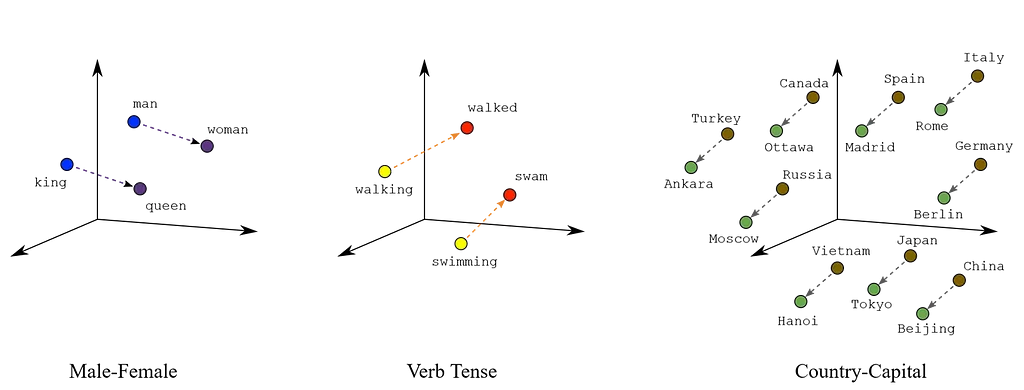

#### Dataset
https://www.kaggle.com/kazanova/sentiment140/data#

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api.

We are going to use 4000 tweets for training our model. The tweets have been annotated (0 = negative, 1 = positive) and they can be used to detect sentiment.


#### Here we are importing the necessary libraries.

 - `pandas` is used to read the dataset.
 - `numpy` is used to perform basic array operations.
 - `Tokenizer` is used to split the text into tokens.
 - `pad_sequences` is used to pad the data if necessary.
 - `train_test_split` from sklearn is used split the data into training and testing dataset.
 - The other components are imported to build the neural network.

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Activation,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalMaxPooling1D,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

`read_csv` is used to load the data into the dataframe. `data.head()` can be used to see the first 5 rows of the dataset.

In [ ]:
df = pd.read_csv("data/twitter4000.csv")
df.head()

In [ ]:
df["sentiment"].value_counts()

Now we will get the text data i.e. the tweets in the form of a list

In [ ]:
text = df["twitts"].tolist()
text

We will get the labels in y.

In [ ]:
y = df["sentiment"]

Now we will use the class `Tokenizer()` to convert the data from text to numbers. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf.

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)
token

`word_index` is `index -> word` dictionary so every word gets a unique integer value. It starts from 0 so we will add 1 to get the `vocab_size`. `vocab_size` is the total number of unique words in our dataset.

In [ ]:
vocab_size = len(token.index_word) + 1
vocab_size

If we consider `x = 'i to the a and'` to be our text, then using token it will be encoded as shown below.

`x = ["i to the a and"]
x = ["1, 2, 3, 4, 6"]`

In [ ]:
token.index_word

In [ ]:
x = ["i to the a and"]
token.texts_to_sequences(x)

In [ ]:
encoded_text = token.texts_to_sequences(text)
encoded_text

We can see that the length of each tweet is different. The length of all encoded tweets must be same before feeding them to the neural network. Hence we are using `pad_sequences` which pads zeros to reviews with length less than `120`.

In [ ]:
max_length = 120
x = pad_sequences(encoded_text, maxlen=max_length, padding="post")
x

In [ ]:
x.shape

Here we are dividing the data into training data and test data using `train_test_split()` from sklearn which we have already imported. We are going to use `80%` of the data for training the model and `20%` of the data for testing. `random_state` controls the shuffling applied to the data before applying the split. `stratify = y` splits the data in a stratified fashion, using y as the class labels.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.2, stratify=y
)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

A `Sequential()` model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

The `Embedding()` layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. It requires 3 arguments:

 - `input_dim`: This is the size of the vocabulary in the text data which is 10135 in our case.
 - `output_dim`: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. We have set it to 300.
 - `input_length`: Length of input sequences, when it is constant. In our case it is 120.

`Conv1D()` is a 1D Convolution Layer, this layer is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment. In the `Conv1D()` layer we are learning a total of `64 filters` with size of convolutional window as `8`. We will be using ReLu activation function. The rectified linear activation function or `ReLU` for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

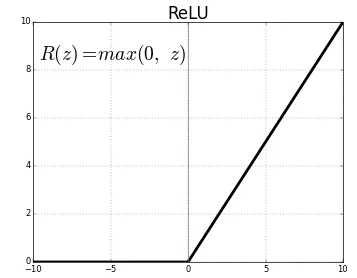

`MaxPool1D()` downsamples the input representation by taking the maximum value over the window defined by pool_size which is 2 in case of this neural network.

`Dropout()` is used to randomly set the outgoing edges of hidden units to 0 at each update of the training phase. The value passed in dropout specifies the probability at which outputs of the layer are dropped out.

`GlobalMaxPooling1D()` downsamples the input representation by taking the maximum value over the time dimension.

`Dense()` is the regular deeply connected neural network layer. The output layer is a dense layer with 1 neuron because we are predicting a single value. `Sigmoid` function is used because it exists between `(0 to 1)` and this facilitates us to predict a binary input.

In [ ]:
vec_size = 300

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(64, 8, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(16, activation="relu"))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation="sigmoid"))

Here we are `compiling` the model and `fitting` it to the training data. We will use 5 epochs to train the model. An `epoch` is an iteration over the entire data provided. `validation_data` is the data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. As `metrics = ['accuracy']` the model will be evaluated based on the `accuracy`.

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
%%time
model.fit(x_train, y_train, epochs = 5, validation_data = (x_test, y_test))

Now we will test the model by predicting sentiments of unseen tweets. We will use the `get_encoded()` to pre-process the reviews in the same way as training data. We can predict the class for new data instances using our finalized classification model in Keras using the `predict_classes()` function.

In [ ]:
def get_encoded(x):
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen=max_length, padding="post")
    return x


x = ["worst services. will not come again"]
model.predict_classes(get_encoded(x))

In [ ]:
x = ["thank you for watching"]
model.predict_classes(get_encoded(x))

We can increase the accuracy of the model by training the model on the entire dataset of 1,600,000 tweets. We can even use more pre-processing techniques like checking for spelling mistakes, repeated letters, etc.